# Advantage Actor Critic

## Imports

In [1]:
import gym
gym.logger.set_level(40)

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta
import os
import glob


from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

from utils.hyperparameters import Config
from utils.plot import plot
from utils.wrappers import make_env_a2c_atari
from agents.BaseAgent import BaseAgent

## Hyperparameters

In [2]:
port=8097
log_dir = "/tmp/gym/"

try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)

config = Config()

#a2c control
config.num_agents=16
config.rollout=5

#misc agent variables
config.GAMMA=0.99
config.LR=7e-4
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5

# Number of updates in 10000000 frames
config.MAX_FRAMES=int(1e7 / config.num_agents / config.rollout)

## Rollout Storage

In [3]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, device):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0

    def insert(self, current_obs, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        self.returns[-1] = next_value
        for step in reversed(range(self.rewards.size(0))):
            self.returns[step] = self.returns[step + 1] * \
                gamma * self.masks[step + 1] + self.rewards[step]

## Network

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCritic, self).__init__()

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0),
                    nn.init.calculate_gain('relu'))

        self.conv1 = init_(nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4))
        self.conv2 = init_(nn.Conv2d(32, 64, kernel_size=4, stride=2))
        self.conv3 = init_(nn.Conv2d(64, 32, kernel_size=3, stride=1))
        self.fc1 = init_(nn.Linear(self.feature_size(input_shape), 512))

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
          lambda x: nn.init.constant_(x, 0))

        self.critic_linear = init_(nn.Linear(512, 1))

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
              lambda x: nn.init.constant_(x, 0), gain=0.01)

        self.actor_linear = init_(nn.Linear(512, num_actions))

        self.train()

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs/255.0))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        value = self.critic_linear(x)
        logits = self.actor_linear(x)

        return logits, value

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

    def layer_init(self, module, weight_init, bias_init, gain=1):
        weight_init(module.weight.data, gain=gain)
        bias_init(module.bias.data)
        return module

## Agent

In [ ]:
class Model(BaseAgent):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__()
        self.device = config.device

        self.noisy=config.USE_NOISY_NETS
        self.priority_replay=config.USE_PRIORITY_REPLAY

        self.gamma = config.GAMMA
        self.lr = config.LR
        self.target_net_update_freq = config.TARGET_NET_UPDATE_FREQ
        self.learn_start = config.LEARN_START
        self.sigma_init= config.SIGMA_INIT
        self.num_agents = config.num_agents
        self.value_loss_weight = config.value_loss_weight
        self.entropy_loss_weight = config.entropy_loss_weight
        self.rollout = config.rollout
        self.grad_norm_max = config.grad_norm_max

        self.static_policy = static_policy
        self.num_feats = env.observation_space.shape
        self.num_feats = (self.num_feats[0] * 4, *self.num_feats[1:])
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99, eps=1e-5)
        
        #move to correct device
        self.model = self.model.to(self.device)

        if self.static_policy:
            self.model.eval()
        else:
            self.model.train()

        self.rollouts = RolloutStorage(self.rollout, self.num_agents,
            self.num_feats, self.env.action_space, self.device)

        self.value_losses = []
        self.entropy_losses = []
        self.policy_losses = []


    def declare_networks(self):
        self.model = ActorCritic(self.num_feats, self.num_actions)

    def get_action(self, s, deterministic=False):
        logits, values = self.model(s)
        dist = torch.distributions.Categorical(logits=logits)

        if deterministic:
            actions = dist.probs.argmax(dim=1, keepdim=True)
        else:
            actions = dist.sample().view(-1, 1)

        log_probs = F.log_softmax(logits, dim=1)
        action_log_probs = log_probs.gather(1, actions)

        return values, actions, action_log_probs
        

    def evaluate_actions(self, s, actions):
        logits, values = self.model(s)

        dist = torch.distributions.Categorical(logits=logits)

        log_probs = F.log_softmax(logits, dim=1)
        action_log_probs = log_probs.gather(1, actions)

        dist_entropy = dist.entropy().mean()

        return values, action_log_probs, dist_entropy

    def get_values(self, s):
        _, values = self.model(s)

        return values

    def compute_loss(self, rollouts):
        obs_shape = rollouts.observations.size()[2:]
        action_shape = rollouts.actions.size()[-1]
        num_steps, num_processes, _ = rollouts.rewards.size()

        values, action_log_probs, dist_entropy = self.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        values = values.view(num_steps, num_processes, 1)
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values
        value_loss = advantages.pow(2).mean()

        action_loss = -(advantages.detach() * action_log_probs).mean()

        loss = action_loss + self.value_loss_weight * value_loss - self.entropy_loss_weight * dist_entropy

        return loss, action_loss, value_loss, dist_entropy

    def update(self, rollout):
        loss, action_loss, value_loss, dist_entropy = self.compute_loss(rollout)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_norm_max)
        self.optimizer.step()

        self.save_loss(loss.item(), action_loss.item(), value_loss.item(), dist_entropy.item())
        #self.save_sigma_param_magnitudes()

        return value_loss.item(), action_loss.item(), dist_entropy.item()

    def save_loss(self, loss, policy_loss, value_loss, entropy_loss):
        super(Model, self).save_loss(loss)
        self.policy_losses.append(policy_loss)
        self.value_losses.append(value_loss)
        self.entropy_losses.append(entropy_loss)

## Training Loop

Updates 10300, Num Timesteps 824080, FPS 1628,
Mean/Median Reward -20.2/-20.5, Min/Max Reward -21.0/-18.0,
Entropy 1.78179, Value Loss 0.00865, Policy Loss 0.00615


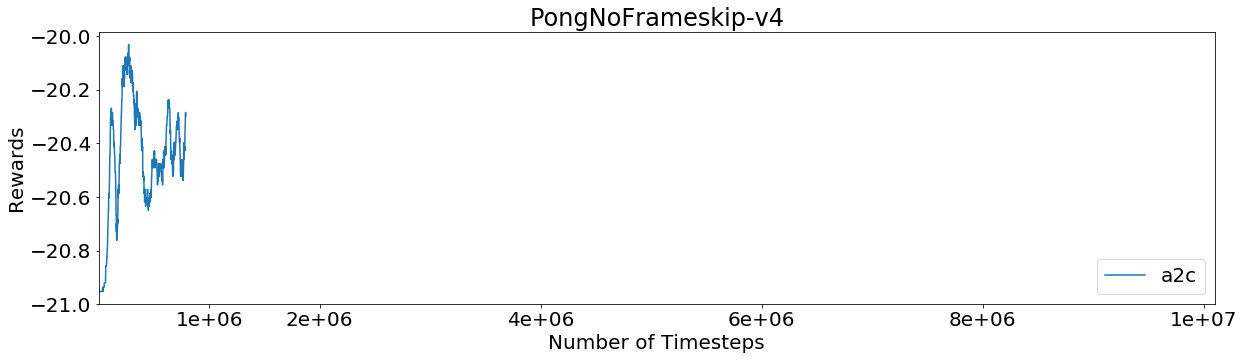

In [ ]:
if __name__=='__main__':
    seed = 1

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    torch.set_num_threads(1)

    env_id = "PongNoFrameskip-v4"
    envs = [make_env_a2c_atari(env_id, seed, i, log_dir) for i in range(config.num_agents)]
    envs = SubprocVecEnv(envs) if config.num_agents > 1 else DummyVecEnv(envs)

    obs_shape = envs.observation_space.shape
    obs_shape = (obs_shape[0] * 4, *obs_shape[1:])

    model = Model(env=envs, config=config)

    current_obs = torch.zeros(config.num_agents, *obs_shape,
                    device=config.device, dtype=torch.float)

    def update_current_obs(obs):
        shape_dim0 = envs.observation_space.shape[0]
        obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)
        current_obs[:, :-shape_dim0] = current_obs[:, shape_dim0:]
        current_obs[:, -shape_dim0:] = obs

    obs = envs.reset()
    update_current_obs(obs)

    model.rollouts.observations[0].copy_(current_obs)
    
    episode_rewards = np.zeros(config.num_agents, dtype=np.float)
    final_rewards = np.zeros(config.num_agents, dtype=np.float)

    start=timer()

    print_step = 1
    print_threshold = 10
    
    for frame_idx in range(1, config.MAX_FRAMES+1):
        for step in range(config.rollout):
            with torch.no_grad():
                values, actions, action_log_prob = model.get_action(model.rollouts.observations[step])
            cpu_actions = actions.view(-1).cpu().numpy()
    
            obs, reward, done, _ = envs.step(cpu_actions)

            episode_rewards += reward
            masks = 1. - done.astype(np.float32)
            final_rewards *= masks
            final_rewards += (1. - masks) * episode_rewards
            episode_rewards *= masks

            rewards = torch.from_numpy(reward.astype(np.float32)).view(-1, 1).to(config.device)
            masks = torch.from_numpy(masks).to(config.device).view(-1, 1)

            current_obs *= masks.view(-1, 1, 1, 1)
            update_current_obs(obs)

            model.rollouts.insert(current_obs, actions.view(-1, 1), action_log_prob, values, rewards, masks)
            
        with torch.no_grad():
            next_value = model.get_values(model.rollouts.observations[-1])

        model.rollouts.compute_returns(next_value, config.GAMMA)
            
        value_loss, action_loss, dist_entropy = model.update(model.rollouts)
        
        model.rollouts.after_update()

        if frame_idx % 100 == 0:
            try:
                clear_output()
                end = timer()
                total_num_steps = (frame_idx + 1) * config.num_agents * config.rollout
                print("Updates {}, Num Timesteps {}, FPS {},\nMean/Median Reward {:.1f}/{:.1f}, Min/Max Reward {:.1f}/{:.1f},\nEntropy {:.5f}, Value Loss {:.5f}, Policy Loss {:.5f}".
                format(frame_idx, total_num_steps,
                       int(total_num_steps / (end - start)),
                       np.mean(final_rewards),
                       np.median(final_rewards),
                       np.min(final_rewards),
                       np.max(final_rewards), dist_entropy,
                       value_loss, action_loss))
                plot(log_dir, "PongNoFrameskip-v4", 'a2c', 
                     config.MAX_FRAMES * config.num_agents * config.rollout)
            except IOError:
                pass

    model.save_w()
    envs.close()

In [ ]:
log_dir